In [246]:
import os
import numpy as np
import pandas as pd
from datetime import date, datetime

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

DATA_ROOT = "input/"

In [85]:
dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [86]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [88]:
dfoff = dfoff[ dfoff['label'] != -1]
print(dfoff.shape)

(746969, 10)


In [87]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [89]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf
dfoff.head(5)

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,0,0,0,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5.0,0,0,0,0,0,1,0,0


In [90]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0
    
def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)
    
def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = df['Distance'].median()
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)
dfoff.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,...,0,1,0,0,0,0,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,...,0,0,0,0,1,0,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,...,0,0,0,1,0,0,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,...,0,0,0,1,0,0,0.90,200,20,1
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5.0,0,...,0,0,0,1,0,0,0.50,10,5,1
6,73611,2099,12034.0,100:10,2.0,20160207.0,NaN,0,7.0,0,...,0,0,0,0,0,1,0.90,100,10,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0,4.0,0,...,0,0,1,0,0,0,0.85,200,30,1
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0,6.0,0,...,0,0,0,0,1,0,0.90,200,20,1
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0,2.0,0,...,1,0,0,0,0,0,0.90,200,20,1
11,253750,8390,7531.0,20:5,0.0,20160327.0,NaN,0,7.0,0,...,0,0,0,0,0,1,0.75,20,5,1


In [106]:
def client_number(df):
    a = df.groupby(['User_id','Merchant_id']).size()
    a = a.reset_index()
    a.columns = ['User_id', 'Merchant_id', 'N client of Merchant']
    df = pd.merge(df, a)
    return df

dfoff = client_number(dfoff)
dftest = client_number(dftest)

In [271]:
def consume_number(df):
    a = df.groupby('User_id').size()
    a = a.reset_index()
    a.columns = ['User_id', 'Consume_number']
    df = pd.merge(df, a)
    return df

dfoff = consume_number(dfoff)
dftest = consume_number(dftest)
dftest.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekday_type,weekday_1,weekday_2,...,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type,N client of Merchant,dist_discount,weekend_days,Consume_number
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,...,1,0,0.866667,150,20,1,1,1.0,4,3
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,0,1,0,...,0,0,0.950000,20,1,1,2,0.0,5,3
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,0,1,0,...,0,0,0.950000,20,1,1,2,0.0,5,3
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,0,1,0,...,0,0,0.833333,30,5,1,1,0.0,5,2
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,...,0,0,0.950000,20,1,1,1,0.0,5,2


In [168]:
def dist_count(df):
    df['dist_discount'] = df['Distance'] ** (1 / df['discount_rate'])
    return df

dfoff = dist_count(dfoff)
dftest = dist_count(dftest)

In [247]:
def get_weekend_days(x):
    if str(x) == 'nan':
        return x
    else:
        days = 4
        day = datetime.strptime(str(int(x)), '%Y%m%d').weekday()
        if day == 4 or day == 5:
            days += 1
        return days

dfoff['weekend_days'] = dfoff['Date_received'].apply(get_weekend_days)
dftest['weekend_days'] = dfoff['Date_received'].apply(get_weekend_days)

In [157]:
print(dfoff.columns)
print(dfoff.shape)
dfoff.head(10)

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'label', 'weekday', 'weekday_type',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'discount_rate', 'discount_man',
       'discount_jian', 'discount_type', 'N client of Merchant',
       'dist_discount'],
      dtype='object')
(746969, 23)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,...,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type,N client of Merchant,dist_discount
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,...,0,0,0,0,0.95,20,1,1,2,0.000000
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,...,0,0,1,0,0.95,20,1,1,2,0.000000
2,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,...,0,1,0,0,0.90,200,20,1,1,0.000000
3,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,...,0,1,0,0,0.90,200,20,1,1,1.000000
4,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5.0,0,...,0,1,0,0,0.50,10,5,1,1,4.000000
5,73611,2099,12034.0,100:10,2.0,20160207.0,NaN,0,7.0,0,...,0,0,0,1,0.90,100,10,1,1,2.160119
6,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0,4.0,0,...,1,0,0,0,0.85,200,30,1,1,15.013107
7,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0,6.0,0,...,0,0,1,0,0.90,200,20,1,1,12.915497
8,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0,2.0,0,...,0,0,0,0,0.90,200,20,1,1,2.160119
9,253750,8390,7531.0,20:5,0.0,20160327.0,NaN,0,7.0,0,...,0,0,0,1,0.75,20,5,1,1,0.000000


In [159]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
   is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
   return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [258]:
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [270]:
original_feature = ['discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday', 
                    'weekday_type',
                   'N client of Merchant',
                   'dist_discount',
                   'weekend_days',
                   'Consume_number'] + weekdaycols
predictors = original_feature
print(predictors)
print(len(original_feature),original_feature)
train[original_feature].head(10)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'N client of Merchant', 'dist_discount', 'weekend_days', 'Consume_number', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']
18 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'N client of Merchant', 'dist_discount', 'weekend_days', 'Consume_number', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekday_type,weekday_1,weekday_2,...,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type,N client of Merchant,dist_discount,weekend_days
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,...,0,1,0,0.866667,150,20,1,1,1.0,4
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,0,1,0,...,0,0,0,0.950000,20,1,1,2,0.0,5
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,0,1,0,...,0,0,0,0.950000,20,1,1,2,0.0,5
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,0,1,0,...,0,0,0,0.833333,30,5,1,1,0.0,5
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,...,0,0,0,0.950000,20,1,1,1,0.0,5
5,2747744,6901,1097.0,50:10,0.0,20160606.0,1,0,1,0,...,0,0,0,0.800000,50,10,1,1,0.0,4
6,196342,1579,10698.0,20:1,1.0,20160606.0,1,0,1,0,...,0,0,0,0.950000,20,1,1,1,1.0,4
7,253750,6901,2366.0,30:5,0.0,20160518.0,3,0,0,0,...,0,0,0,0.833333,30,5,1,1,0.0,5
8,343660,4663,11002.0,150:20,0.0,20160528.0,6,0,0,0,...,0,1,0,0.866667,150,20,1,1,0.0,4
9,1113008,3621,2705.0,20:5,0.0,20160524.0,2,0,0,1,...,0,0,0,0.750000,20,5,1,1,0.0,4


In [73]:
predictors = original_feature
print(predictors)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type']


In [ ]:


# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import roc_auc_score
# clf = GradientBoostingClassifier(random_state=1, n_estimators=10, max_depth=7)
# n_estimators = [5, 7, 10, 15]
# max_depth = [3, 5, 7, 10]
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
# #grid_seach = GridSearchCV(clf, param_grid, scoring='roc_auc', verbose=1)
# grid_result = clf.fit(train[predictors], train['label'])
# #grid_result = grid_search.fit(train[predictors], train['label'])
# #print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [261]:
eta = [0.9, 0.5]
max_depth = [10, 7]
gamma = [0.1, 0.2]
param_grid = dict(eta=eta, max_dept=max_depth, gamma=gamma)
clf = XGBClassifier(nthread=2)
grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(train[predictors], train['label'])
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 21.2min finished


Best Accuracy: 0.856751 using {'eta': 0.9, 'gamma': 0.2, 'max_dept': 10}


In [262]:
from xgboost import XGBClassifier 
model = XGBClassifier(eta=0.9, max_depth=10, nthread=2, min_child_weight=5, gamma=0.2)
model.fit(train[predictors], train['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.9, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=2, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [194]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    max_depth=10
)
model.fit(train[predictors], train['label'])
print('importance = {}'.format(model.feature_importances_))

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


importance = [0.0919633  0.00455451 0.15450179 0.06890736 0.12874965 0.01952488
 0.         0.38552305 0.12135289 0.00259012 0.00388912 0.00340763
 0.00206283 0.00664005 0.00301768 0.00331514]


In [204]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    penalty='l2'
)
model.fit(train[predictors], train['label'])

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [213]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=30, max_features=7,
                                  max_depth=6, learning_rate=0.3)
model.fit(train[predictors], train['label'])
print('importance = {}'.format(model.feature_importances_))

importance = [0.04502516 0.01655311 0.17058441 0.09994349 0.18300066 0.03113818
 0.         0.34790861 0.07668168 0.00216816 0.00321174 0.00361161
 0.00396903 0.00852504 0.00236245 0.00531666]


In [232]:
from mlxtend.classifier import StackingClassifier
gb = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=30, max_features=7,
                                  max_depth=6, learning_rate=0.3)
lr = LogisticRegression(penalty='l2')
rf = RandomForestClassifier(max_depth=10)
xg = XGBClassifier(eta=0.9, max_depth=10, nthread=2, min_child_weight=5)
meta_estimator = lr
model = StackingClassifier(classifiers=[lr,rf,gb, xg], meta_classifier=meta_estimator)
model.fit(train[predictors], train['label'])

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\benja\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='warn', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                      

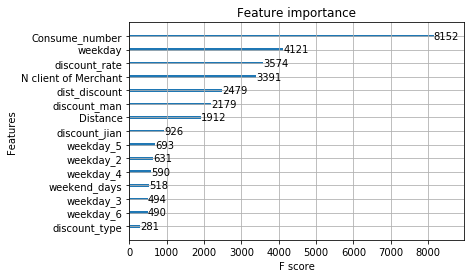

In [263]:
from xgboost import plot_importance
plot_importance(model, max_num_features = 15)

In [264]:
y_pred = model.predict_proba(valid[predictors])
score = roc_auc_score(valid['label'], y_pred[:,1])
print(score)

0.8248092020075031


In [265]:
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]

In [266]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.825, Accuracy: 0.953


In [272]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

(306313, 23)
(306313, 19)


In [273]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306313, 4)


In [274]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("baseline_example.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.215717
1,1000020_8192_20160513,0.210658
2,1000065_1455_20160527,0.021504
3,1000085_8067_20160513,0.107650
4,1000086_2418_20160613,0.145524
